---

# Lecture 5.1 Single Neuron Logistic Regression

In this notebook we revisit machine learning classification problems. More specifically, we consider the *probabilistic binary classfication problem*. We model this problem as a single neuron model with the *binary cross entropy loss function*. As with single neuron linear regression, we will train our neuron with stochastic gradient descent. 

## Why Probabilistic Modeling?
In previous binary classification problems, such as when we applied the perceptron single neuron model, we were assuming that our data was linearly seperable. For example, consider the two figures generated by running the following code. 
```python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boudaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Read the iris dataset into a pandas DataFrame object
df = pd.read_csv("Datasets/iris_dataset.csv")

setosa = df[df.species == "setosa"]
versicolor = df[df.species == "versicolor"]
virginica = df[df.species == "virginica"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.scatter(setosa.sepal_length, 
            setosa.sepal_width, 
            color = "red", 
            label = "setosa")
ax1.scatter(versicolor.sepal_length, 
            versicolor.sepal_width, 
            color = "magenta", 
            label = "versicolor")
ax1.set_xlabel("sepal length [cm]", fontsize = 15)
ax1.set_ylabel("sepal width [cm]", fontsize = 15)
ax1.legend(fontsize = 15, loc = "upper left")
ax1.set_title("Linearly Seperable Data", fontsize = 18)


ax2.scatter(versicolor.sepal_length, 
            versicolor.sepal_width, 
            color = "magenta", 
            label = "versicolor")
ax2.scatter(virginica.sepal_length, 
            virginica.sepal_width, 
            color = "lightseagreen", 
            label = "virginica")
ax2.set_xlabel("sepal length [cm]", fontsize = 15)
ax2.set_ylabel("sepal width [cm]", fontsize = 15)
ax2.legend(fontsize = 15, loc = "upper left")
ax2.set_title("Non-Linearly Seperable Data", fontsize = 18)

```



---

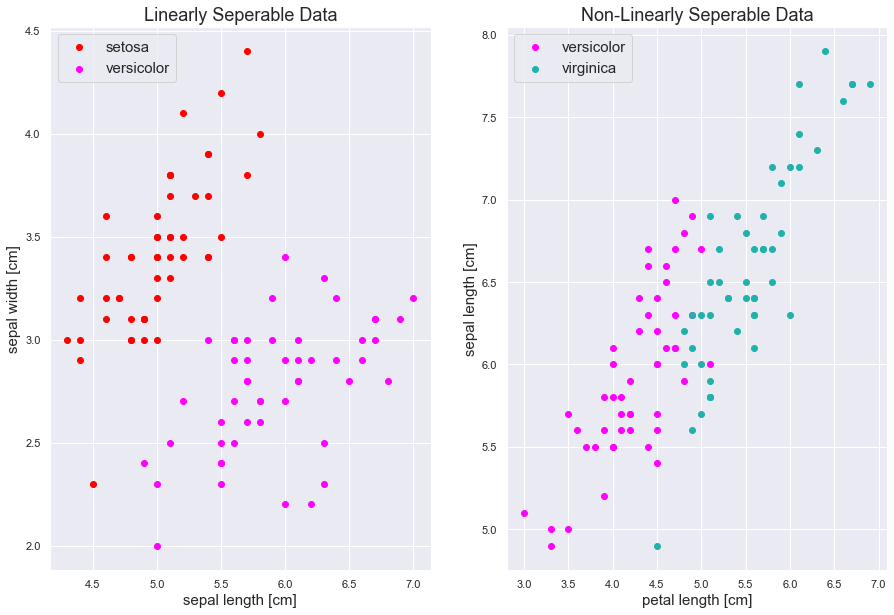

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boudaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Read the iris dataset into a pandas DataFrame object
df = pd.read_csv("Datasets/iris_dataset.csv")

setosa = df[df.species == "setosa"]
versicolor = df[df.species == "versicolor"]
virginica = df[df.species == "virginica"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.scatter(setosa.sepal_length, 
            setosa.sepal_width, 
            color = "red", 
            label = "setosa")
ax1.scatter(versicolor.sepal_length, 
            versicolor.sepal_width, 
            color = "magenta", 
            label = "versicolor")
ax1.set_xlabel("sepal length [cm]", fontsize = 15)
ax1.set_ylabel("sepal width [cm]", fontsize = 15)
ax1.legend(fontsize = 15, loc = "upper left")
ax1.set_title("Linearly Seperable Data", fontsize = 18)


ax2.scatter(versicolor.petal_length, 
            versicolor.sepal_length, 
            color = "magenta", 
            label = "versicolor")
ax2.scatter(virginica.petal_length, 
            virginica.sepal_length, 
            color = "lightseagreen", 
            label = "virginica")
ax2.set_xlabel("petal length [cm]", fontsize = 15)
ax2.set_ylabel("sepal length [cm]", fontsize = 15)
ax2.legend(fontsize = 15, loc = "upper left")
ax2.set_title("Non-Linearly Seperable Data", fontsize = 18)
plt.show()

---

As you can see in the left figure generated above, it is impossible to split the versicolor and virginica flowers by any linear function. The reason for this is that the two species of flowers on the left overlap in the same regions of space. However, notice that in the non-linearly seperable case, the probability of selecting a versicolor flower is higher than the probability of selecting a virginica flower whenever petal length is less that 4.75. Conversely, the probability of selecting a virginica flower is higher than the probability of selecting a versicolor flower whenever the petal length is higher than 4.75. 

Observing this, label each versicolor flower by 0 and each virginica flower by 1. Then, only using the petal length as our feature measurment observe the figure generated by running the following code in the cell below. 
```python
plt.figure(figsize = (10, 8))
plt.xlim((2.75, 7 ))
plt.scatter(versicolor.petal_length, 
            np.zeros(50), 
            color = "magenta", 
            label = "versicolor")
plt.scatter(virginica.petal_length, 
            np.ones(50), 
            color = "lightseagreen", 
            label = "virginica")
plt.vlines(4.75, 0.0, 1.0)
plt.xlabel("petal length [cm]", fontsize = 15)
plt.ylabel("label", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("Non-Linearly Seperable Data", fontsize = 18)
plt.show()
```


---

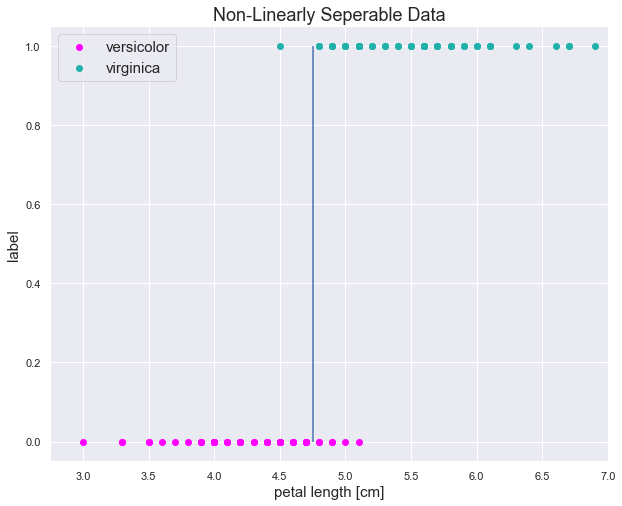

In [27]:
plt.figure(figsize = (10, 8))
plt.xlim((2.75, 7 ))
plt.scatter(versicolor.petal_length, 
            np.zeros(50), 
            color = "magenta", 
            label = "versicolor")
plt.scatter(virginica.petal_length, 
            np.ones(50), 
            color = "lightseagreen", 
            label = "virginica")
plt.vlines(4.75, 0.0, 1.0)
plt.xlabel("petal length [cm]", fontsize = 15)
plt.ylabel("label", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("Non-Linearly Seperable Data", fontsize = 18)
plt.show()

---

## Designing a Single Neuron to Predict Probabilities
Instead of creating a single neuron model for predicting a class deterministic label, we will next build a single neuron model that predicts a *class probability*. First, recall the general single neuron model depicted in the following figure. 

The Single Neuron Model
---

<p align="center">
    <img src="general_single_neuron.png" width="500">
</p>

---

### The Sigmoid Activation Function

As before (both with the linear regression and Perceptron single neurons), we must first decide on an activation function before deciding on a cost/ loss function. For this purpose, we choose the *sigmoid* activation function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

This differentiable function has a range in $(0, 1)$, so it would seem suitable for a possible function to turn the pre-activation value into a value representing a probability. Moreover, the sigmoid function (sometimes called the *logistic function*) has a smooth "S"-shape that is perfect for probabilities values transitioning, either growing or shrinking, as the input feature changes. For example, run the following code in the cell below. 
```python
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.set_xlim((2.75, 7))
ax1.scatter(versicolor.petal_length, 
            np.zeros(50), 
            color = "magenta", 
            label = "versicolor")
ax1.scatter(virginica.petal_length, 
            np.ones(50), 
            color = "lightseagreen", 
            label = "virginica")
ax1.set_xlabel("petal length [cm]", fontsize = 15)
ax1.set_ylabel("label", fontsize = 15)
ax1.set_title("Non-Linearly Seperable Data", fontsize = 18)


domain = np.linspace(-12.0, 12.0, 100)
ax2.plot(domain, 
        sigmoid(domain), 
        color = "blue", 
        label = "$\sigma$(z)")
ax2.set_xlabel("z = wx + b", fontsize = 18)
ax2.set_ylabel("$sigma(z)$", fontsize = 15)
ax2.set_title("The Sigmoid Function", fontsize = 18)
plt.show()
```

---

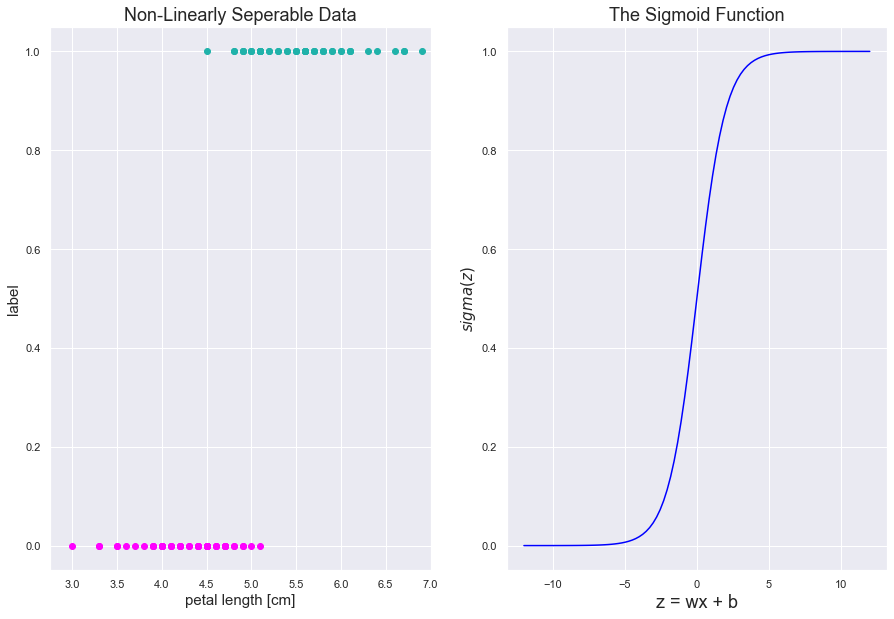

In [33]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.set_xlim((2.75, 7))
ax1.scatter(versicolor.petal_length, 
            np.zeros(50), 
            color = "magenta", 
            label = "versicolor")
ax1.scatter(virginica.petal_length, 
            np.ones(50), 
            color = "lightseagreen", 
            label = "virginica")
ax1.set_xlabel("petal length [cm]", fontsize = 15)
ax1.set_ylabel("label", fontsize = 15)
ax1.set_title("Non-Linearly Seperable Data", fontsize = 18)


domain = np.linspace(-12.0, 12.0, 100)
ax2.plot(domain, 
        sigmoid(domain), 
        color = "blue", 
        label = "$\sigma$(z)")
ax2.set_xlabel("z = wx + b", fontsize = 18)
ax2.set_ylabel("$sigma(z)$", fontsize = 15)
ax2.set_title("The Sigmoid Function", fontsize = 18)
plt.show()

---

As can be seen by the two figures generated above, the petal pre-activation value might be able to map the petal length measurements to the correct inputs to the sigmoid function so that the post-activation values correctly describe the probability of observing a versicolor flower or a virginica flower. In order to test this hypothesis, we must next introduce a cost/loss function to our single neuron model. 

## The Binary Cross Entropy Loss Function 
Currently we have two target values, 0 for versicolor and 1 for virginica. Moreover, we are wishing to predict that *probability of each of these labels given a single feature measurement*. Thus, we encounter the conditional probability function:

$$
P\Big(y^{(i)}\mid x^{(i)}\Big)=\begin{cases}
          \hat{y}^{(i)}, \quad &  y^{(i)} = 1 \\
          1-\hat{y}^{(i)}, \quad & y^{(i)} = 0 \\
     \end{cases}
$$

Notice that this conditional probability depends on the value of $\hat{y}^{(i)}$, which in-turn depends on the values of our weight and bias. Moreover, we wish to *maximize* this probability over all training examples since this quantity is largest when our predicted probabilities are close approximations to the true 0-1 labels. Thus, we seek to solve the following maximization problem:

$$
\max_{\mathbf{w}, b} \sum_{i=1}^{N}P\Big(y^{(i)}\mid x^{(i)}\Big).
$$

Before considering this optimization problem, we next recall the famous Bernoulli formula for binary probabilities:
$$
P\Big(y^{(i)}\mid x^{(i)}\Big) = [\hat{y}^{(i)}]^{y}[1 - \hat{y}^{(i)}]^{(1-y)}
$$

Taking the logorithm on both sides of this equation yields (dropping the index notation to avoid messy equations):
$$
\begin{align} 
\log P\Big(y^{(i)}\mid x^{(i)}\Big)&= \log \hat{y}^{y}(1 - \hat{y})^{(1-y)}\\ 
&= y\log \hat{y} + (1-y) \log (1 - \hat{y})\\ 
\end{align}
$$

Since the logorithmic function is an *increasing function*, maximimizing $P\Big(y^{(i)}\mid x^{(i)}\Big)$ is equivalent to maximizing $\log P\Big(y^{(i)}\mid x^{(i)}\Big)$. Equivalently, we could also considering minimizing this function. Thus, we arrive at our single neuron coss/loss function for a single entry of data, which implies a full loss function. 

### Binary Cross Entropy Loss Function:
$$
L(\mathbf{w}, b) = -\frac{1}{N} \sum_{i=1}^{N} P\Big(y^{(i)}\mid x^{(i)}\Big) = \frac{1}{N}\sum_{i=1}^{N}\Big[ -y^{(i)}\log \hat{y}^{(i)} - (1-y^{(i)}) \log (1 - \hat{y}^{(i)})\Big ]
$$

Now that we have a plausible loss function, we have a complete single neuron model ready for training; see the figure below. 

---